In [11]:
import numpy as np
import pandas as pd
import os
import calendar
import sys
import matplotlib.pyplot as plt
#import seaborn as sns
import tensorflow as tf
import keras
from keras import layers
from util import stack_all_wells

%matplotlib inline

plt.rc('font', family='serif')

WELL_DATA_PATH_MODIFIED = os.getcwd() + '/data/well-time-series-modified/'

In [2]:
drop_parameters = ['Date',
                   'Date_Month',
#                   'year',
                   'site_no',
                   'X_72019_00001']

all_wells = stack_all_wells(path = WELL_DATA_PATH_MODIFIED,
                            drop_parameters = drop_parameters)

# after March, before October
all_wells = all_wells[(all_wells['yday']>60) & (all_wells['yday']<280)]
"""
all_wells['dprcpdt'] = np.nan
all_wells['dtmaxdt'] = np.nan
all_wells['dtmindt'] = np.nan

all_wells['dprcpdt'] = all_wells['prcp (mm/day)'].diff(1)
all_wells['dtmaxdt'] = all_wells['tmax (deg c)'].diff(1)
all_wells['dtmindt'] = all_wells['tmin (deg c)'].diff(1)
"""
all_wells['deltaT'] = all_wells['tmax (deg c)'] - all_wells['tmin (deg c)']

all_wells = all_wells.dropna()
all_wells_subset = all_wells #[(all_wells['dhdt']<3) & (all_wells['dhdt']>-3)]

all_wells_subset = all_wells_subset.reset_index()

appended 412522100121201_11740_lat_41.42277778_lon_-100.2033778_2019-08-08_224716_modified.csv
appended 414643100313101_11740_lat_41.7785861_lon_-100.5251611_2019-08-08_224925_modified.csv
appended 405738099504501_11741_lat_40.96063889_lon_-99.8457778_2019-08-08_224507_modified.csv
appended 402912096231601_11742_lat_40.4866662_lon_-96.3880693_2019-08-08_224024_modified.csv
appended 405737101423201_11740_lat_40.95999535_lon_-101.7085057_2019-08-08_224500_modified.csv
appended 420006102561201_11739_lat_42.00194444_lon_-102.9561111_2019-08-08_225029_modified.csv
appended 404743096401001_11742_lat_40.7952789_lon_-96.6697378_2019-08-08_224248_modified.csv
appended 413130100531202_11740_lat_41.52505556_lon_-100.8883889_2019-08-08_224744_modified.csv
appended 405118099514901_11741_lat_40.8550833_lon_-99.8635833_2019-08-08_224336_modified.csv
appended 403954099152101_11741_lat_40.66491667_lon_-99.2558944_2019-08-08_224137_modified.csv
appended 404804096403301_11742_lat_40.80105556_lon_-96.6762

appended 404724096402201_11742_lat_40.79000116_lon_-96.6730713_2019-08-08_224236_modified.csv
appended 404519101170301_11740_lat_40.74083478_lon_-101.284882_2019-08-08_224203_modified.csv
appended 403356097275602_11742_lat_40.56556147_lon_-97.4658824_2019-08-08_224104_modified.csv
appended 413156098591201_11741_lat_41.53223249_lon_-98.9870332_2019-08-08_224750_modified.csv
appended 415108099493401_11741_lat_41.8525017_lon_-99.8273468_2019-08-08_224945_modified.csv
appended 404836097584101_11742_lat_40.81001158_lon_-97.9783863_2019-08-08_224311_modified.csv
appended 414952100060301_11740_lat_41.83110278_lon_-100.1008667_2019-08-08_224931_modified.csv
appended 401735098522701_11741_lat_40.29306924_lon_-98.8745226_2019-08-08_223949_modified.csv
appended 404757096405001_11742_lat_40.79916789_lon_-96.6808492_2019-08-08_224259_modified.csv
appended 410943097575001_11742_lat_41.16177778_lon_-97.9639028_2019-08-08_224559_modified.csv
appended 411736096170201_11742_lat_41.2932222_lon_-96.28375_

In [3]:
## train test splitting
train_dataset = all_wells_subset.sample(frac=0.7, random_state=101)
test_dataset = all_wells_subset.drop(train_dataset.index)

train_stats = train_dataset.describe()
train_stats.pop("dhdt")
train_stats = train_stats.transpose()

train_labels = train_dataset.pop('dhdt')
test_labels = test_dataset.pop('dhdt')

In [4]:
#normalize
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [63]:
# model dev
def build_model():
    model = keras.Sequential([
    layers.Dense(32, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dropout(0.5),
    layers.Dense(16, activation=tf.nn.relu),
    layers.Dropout(0.1),
#    layers.Dense(256, activation=tf.nn.sigmoid),
    layers.Dense(1)
    ])

#    optimizer = keras.optimizers.RMSprop(0.001)
#    optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0, amsgrad=False)
    optimizer = keras.optimizers.Adadelta(lr=0.1, rho=0.95, epsilon=None, decay=0.0)
#    optimizer = keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_squared_error'])
    return model

model = build_model()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [64]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 10 == 0: print('')
        print('.', end='')

In [65]:
EPOCHS = 50

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=1, callbacks=[PrintDot()], batch_size=32)
#                    validation_split = 0.2, verbose=1, callbacks=[early_stop, PrintDot()])


Train on 61412 samples, validate on 15353 samples
Epoch 1/50
61412/61412 [==============================] - 2s 30us/step - loss: 0.8863 - mean_squared_error: 0.8863 - val_loss: 0.5965 - val_mean_squared_error: 0.5965

.Epoch 2/50
61412/61412 [==============================] - 2s 37us/step - loss: 0.6196 - mean_squared_error: 0.6196 - val_loss: 0.5834 - val_mean_squared_error: 0.5834
.Epoch 3/50
61412/61412 [==============================] - 2s 32us/step - loss: 0.5945 - mean_squared_error: 0.5945 - val_loss: 0.5800 - val_mean_squared_error: 0.5800
.Epoch 4/50
61412/61412 [==============================] - 2s 33us/step - loss: 0.5865 - mean_squared_error: 0.5865 - val_loss: 0.5777 - val_mean_squared_error: 0.5777
.Epoch 5/50
61412/61412 [==============================] - 2s 25us/step - loss: 0.5810 - mean_squared_error: 0.5810 - val_loss: 0.5766 - val_mean_squared_error: 0.5766
.Epoch 6/50
61412/61412 [==============================] - 2s 29us/step - loss: 0.5781 - mean_squared_error: 0

61412/61412 [==============================] - 2s 31us/step - loss: 0.5710 - mean_squared_error: 0.5710 - val_loss: 0.5715 - val_mean_squared_error: 0.5715
.Epoch 50/50
61412/61412 [==============================] - 1s 24us/step - loss: 0.5707 - mean_squared_error: 0.5707 - val_loss: 0.5714 - val_mean_squared_error: 0.5714
.

In [66]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

val_loss  val_mean_squared_error      loss  mean_squared_error  epoch
45  0.571594                0.571594  0.571027            0.571027     45
46  0.571537                0.571537  0.571035            0.571035     46
47  0.571595                0.571595  0.571360            0.571360     47
48  0.571485                0.571485  0.570952            0.570952     48
49  0.571443                0.571443  0.570739            0.570739     49

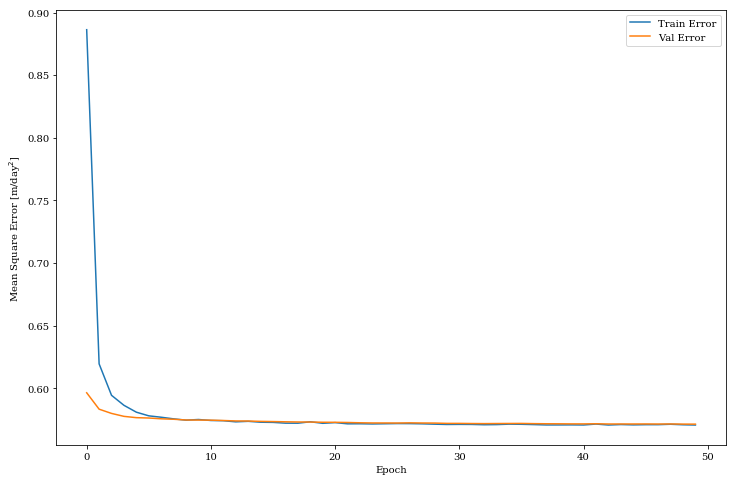

In [67]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    """
    plt.figure(figsize=(12,8))
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [m/day]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
#    plt.ylim([0,5])
    plt.legend()
    """
    plt.figure(figsize=(12, 8))
    plt.xlabel('Epoch')
    plt.ylabel(r'Mean Square Error [m/day$^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
#    plt.ylim([0,20])
    plt.legend()
    plt.savefig('./figs/keras-test.png',dpi=300)

plot_history(history)

<Figure size 432x288 with 0 Axes>

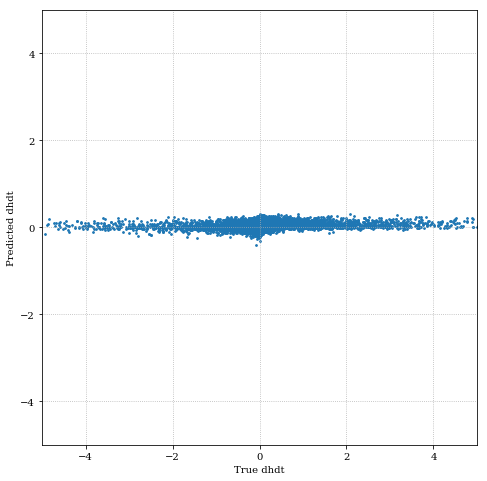

In [68]:
test_predictions = model.predict(normed_test_data).flatten()

plt.clf()
plt.figure(figsize=(8,8))
plt.scatter(test_labels, test_predictions, s=3)
plt.xlabel('True dhdt')
plt.ylabel('Predicted dhdt')
plt.axis('equal')
plt.axis('square')
plt.grid(linestyle='dotted')
plt.xlim([-5,5])
plt.ylim([-5,5])
plt.savefig('./figs/keras-prediction.png', dpi=300)